# (All Data) Get At-Risk Customers Using Business Metrics

In [1]:
import os
from datetime import datetime
from pathlib import Path

import boto3
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from IPython.display import Markdown

In [2]:
PROJ_ROOT = Path.cwd().parent

In [3]:
assert load_dotenv(dotenv_path=PROJ_ROOT.parent / '.env')

In [4]:
import r2.io_utils as r2io
import cc_churn.costs as costs
import cc_churn.visualization as vzu

## About

Get the at-risk customers and predicted ROI using all available data.

## User Inputs

In [5]:
# best model name
best_model_name = 'histgradientboostingclassifier'

# R2 data bucket details
bucket_name = 'cc-churn-splits'

# columns to load
columns = [
    'clientnum',
    'card_category',
    'total_revolv_bal',
    'total_trans_amt',
    'model_name',
    'y_pred_proba',
    'y_pred',
    'best_decision_threshold',
    'is_churned',
]

# costs
# # revenue from transactions (bank earns #% of transaction volume)
interchange_rate = 0.02
# # revenue from revolving balance (~20% interest)
apr = 0.18
# # fee revenue from credit card exposure (modeled from card type)
card_fees = {"Blue": 0, "Silver": 50, "Gold": 100, "Platinum": 200}
tenure_years = 3
discount = 0.9
# # percentage of churners who can be convinced to stay (i.e. success rate
# # of saving a churning customer)
success_rate = 0.40
# # cost of intervention to get a single customer to not churn (discounts,
# # call center time, retention offers, etc.)
intervention_cost = 50
# # maximum number of customers that can be targeted based on client's budget
num_customers_max = 100

In [6]:
account_id = os.getenv('ACCOUNT_ID')
access_key_id = os.getenv('ACCESS_KEY_ID')
secret_access_key = os.getenv('SECRET_ACCESS_KEY')

# R2 data bucket details
# # name of all data with predictions key (file) in private R2 bucket
r2_key_all_partial = f'all_predictions__{best_model_name}__'
# # name of validation data with predictions key (file) in private R2 bucket
r2_key_val_partial = f'validation_predictions__{best_model_name}__'

s3_client = boto3.client(
    's3',
    endpoint_url=f'https://{account_id}.r2.cloudflarestorage.com',
    aws_access_key_id=access_key_id,
    aws_secret_access_key=secret_access_key,
    region_name='auto'
)

# costs
multiplier = (1 - discount**tenure_years) / (1 - discount)

## Load Data with Predictions

Load all available data with predictions

In [ ]:
%%time
df_all_pred = r2io.pandas_read_filtered_parquets_r2(
    s3_client, bucket_name, r2_key_all_partial, columns
)
print(f"Got {len(df_all_pred):,} rows of all available data")
with pd.option_context('display.max_columns', None):
    display(df_all_pred)

Extract best decision threshold and name of best ML model from model predictions of the validation data

In [8]:
%%time
best_decision_threshold, best_model_name = r2io.pandas_read_filtered_parquets_r2(
    s3_client=s3_client,
    bucket_name=bucket_name,
    key_prefix=r2_key_val_partial,
    cols_to_load=['best_decision_threshold', 'model_name'],
).head(1).squeeze().to_list()

CPU times: user 16.9 ms, sys: 991 μs, total: 17.9 ms
Wall time: 186 ms


## All Available Data

### Class Imbalance

Get the true and predicted class imbalance for all available data

In [9]:
%%time
df_true_pred_class_imbalance = (
    (
        df_all_pred['y_pred']
        .value_counts(normalize=True)
        .rename('predicted')
        .to_frame()
    )
    .merge(
        (
            df_all_pred['is_churned']
            .value_counts(normalize=True)
            .rename('true')
            .to_frame()
        ),
        left_index=True,
        right_index=True,
    )
)
df_true_pred_class_imbalance.index = df_true_pred_class_imbalance.index.map(
    {0: 'No Churn', 1: 'Churn'}
)
churn_true = (df_true_pred_class_imbalance.loc['Churn'].mul(100))['true']
churn_pred = (df_true_pred_class_imbalance.loc['Churn'].mul(100))['predicted']
df_true_pred_class_imbalance

CPU times: user 9.38 ms, sys: 1.92 ms, total: 11.3 ms
Wall time: 9.72 ms


,predicted,true
y_pred,,
No Churn,0.851486,0.83934
Churn,0.148514,0.16066


**Observations**

1. The predicted churn in all avilable data is approximately 2% lower than that in the true data (~84%:16%).
2. It is reassuring that the true and predicted class imbalance are close to each other.

Show the class imbalance and distribution of prediction probabilities for all available data

CPU times: user 66.9 ms, sys: 2 ms, total: 68.9 ms
Wall time: 68.2 ms


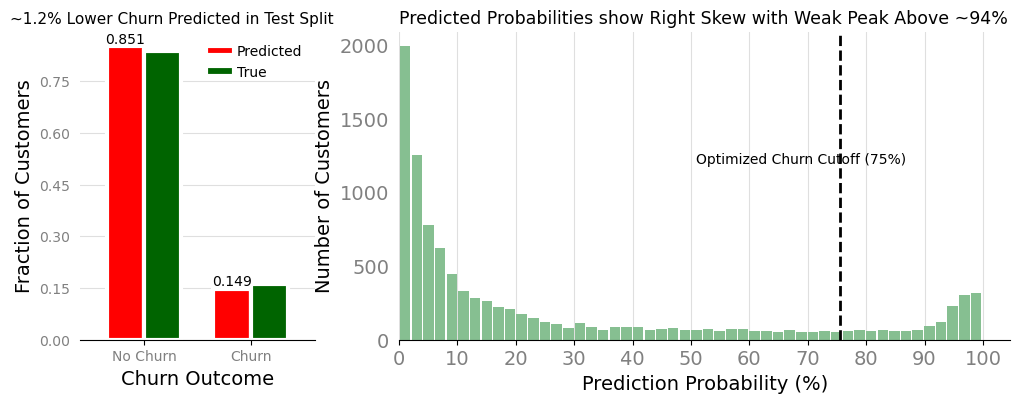

In [10]:
%%time
vzu.plot_class_imbalance_proba_distribution(
    df_class_imbalance=df_true_pred_class_imbalance.rename(columns=str.title),
    df_probabilities=(df_all_pred['y_pred_proba']*100),
    ptitle1='~1.2% Lower Churn Predicted in Test Split',
    title1_xloc=-0.3,
    ptitle2=(
        'Predicted Probabilities show Right Skew with Weak Peak Above ~94%'
    ),
    vline_label=f'Optimized Churn Cutoff ({best_decision_threshold*100:.0f}%)',
    decision_threshold=best_decision_threshold,
    subfigure_width_ratios=[1.15, 3],
    fig_size=(12, 4)
)

**Observations**

1. Similar to the test split, the distribution of predicted probabilities shows a right-skew.

### Costs

Calculate the true savings, expected (predicted) savings and error in predicted savings (cost) using all available data

In [ ]:
%%time
df_costs_all, _, _ = costs.get_cost(
    df_all_pred,
    best_decision_threshold,
    interchange_rate,
    apr,
    card_fees,
    multiplier,
    success_rate,
    intervention_cost,
)
with pd.option_context('display.max_columns', None):
    display(df_costs_all)

### Get Optimal Number of Targeted Customers (`N`)

Plot true and predicted expected savings and ROI curves to visualize the following

1. true ROI
2. predicted ROI

using all available data

CPU times: user 17 ms, sys: 62 μs, total: 17.1 ms
Wall time: 16.4 ms


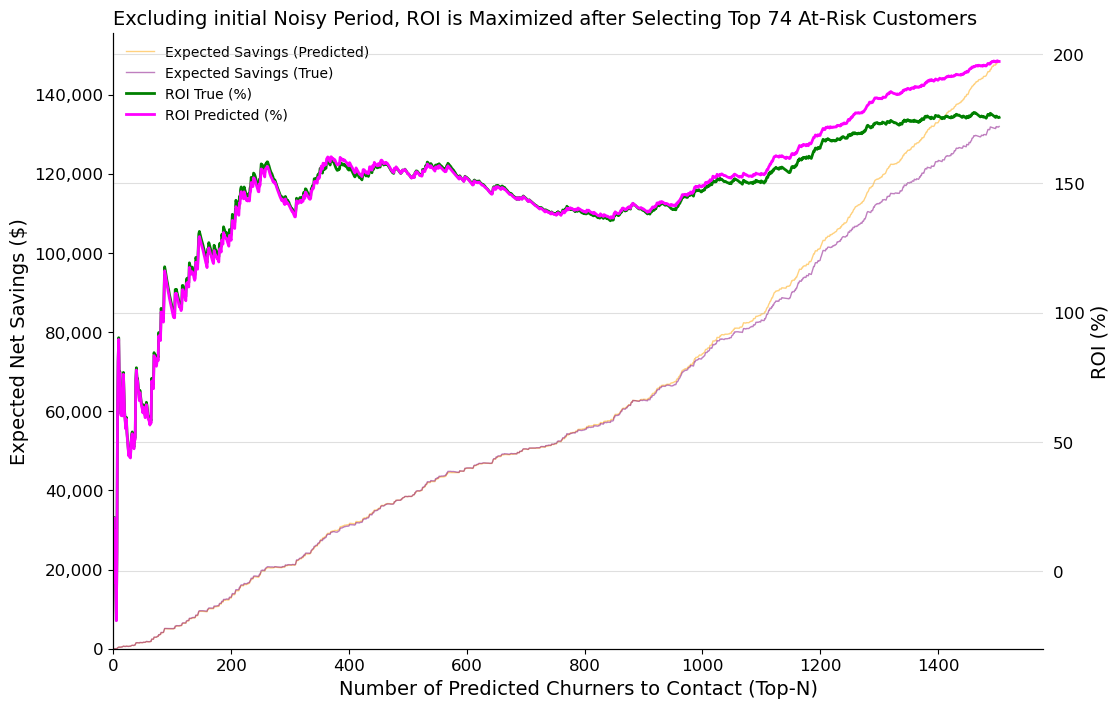

In [12]:
%%time
vzu.plot_roi_curves(
    df_costs_all['n'],
    df_costs_all['cum_true_savings'],
    df_costs_all['cum_pred_savings'],
    df_costs_all['ROI_percent'],
    df_costs_all['ROI_percent_pred'],
    {},
    ptitle=(
        'Excluding initial Noisy Period, ROI is Maximized after Selecting Top '
        '74 At-Risk Customers'
    ),
    legend_loc='upper left',
    xlabel=f"Number of Predicted Churners to Contact (Top-N)",
    ylabel="Expected Net Savings ($)",
    fig_size=(12, 8),
)

**Observations**

1. (similar to the test split) Due to the accuracy of the best ML model, the true and predicted ROI curves are close to each other. As a result, the optimal number can be safely determined in order to maximize true ROI, without needing to emphasize minimizing error in predicted ROI.
2. Customers with a high `total_revolv_bal` account for the sharp increase in ROI, resulting in a peak at ~400 customers. Between ~400 and ~900 customers, there are minimal such customers so further sharp increases are not seen. As mentioned in the previous notebook, selecting as many high `total_revolv_bal` customers as possible captures steep increases in ROI. Between ~900 and ~1,500, the high `total_revolv_bal` customers appear again.
3. If the budget allows for targeting at most the top 1,000 customers (~10% of all customers in the random sample) then the optimal number of customers is ~400.
4. If there is room in the budget to target all possible at-risk cutomers then the optimal number of customers is ~1,500. Here, we will assume this is true. So, the optimal number customers to be targeted is ~1,500.

Find the optimal number of customers to target in order to maximize true ROI, using the costs on all available data

In [13]:
%%time
df_costs_optimal = (
    df_costs_all
    .query(
        "(total_intervention_cost > 0) & "
        # capture second peak in ROI
        "(n >= 750)"
    )
    .sort_values(
        by=['ROI', 'ROI_error', 'n'], ascending=[False, True, True],
        ignore_index=True,
    )
    .head(1)
)
optimal_N_roi = df_costs_optimal['n'].squeeze()
cols_costs = [
    'n',
    'y_pred_proba',
    'cum_true_savings',
    'cum_pred_savings',
    'ROI_percent',
    'ROI_percent_pred',
    'ROI_error',
]
(
    df_costs_optimal[cols_costs]
    .style
    .set_properties(
        subset=['ROI_error', 'ROI_percent_pred'],
        **{'background-color': 'yellow', 'color': 'black'}
    )
)

CPU times: user 43.4 ms, sys: 3.03 ms, total: 46.4 ms
Wall time: 45.7 ms


,n,y_pred_proba,cum_true_savings,cum_pred_savings,ROI_percent,ROI_percent_pred,ROI_error
0,1461,0.767892,129608.352800,142582.566084,177.424165,195.184895,-10.010322


### Get Loss in Predicted ROI Using Optimized Number of Targeted Customers (`N`)

Calculate error in *predicted* ROI if the optimal number of predicted churners (top 1,461) are contacted from all available data

In [14]:
roi_error_optimal_val = df_costs_optimal['ROI_error'].squeeze()
predicted_roi_optimal_val = df_costs_optimal['ROI_percent_pred'].squeeze()
Markdown(
    "**Observations**\n"
    "1. In order to minimize the error in predicted ROI while also maximizing "
    f"true ROI, the optimal number of customers to target is {optimal_N_roi:,}. "
    "This is consistent with observations from the chart above.\n"
    f"2. If the top {optimal_N_roi:,} customers from the test data are "
    "targeted, then the\n"
    "   - error in the predicted ROI is approximately "
    f"{roi_error_optimal_val:.2f}%\n"
    f"   - predicted ROI is approximately {predicted_roi_optimal_val:.1f}%\n"
    "3. If we apply these recommendations from predicted ROI and contact "
    f"(target) the top {optimal_N_roi:,} customers, then the client is "
    f"incorrectly reported this gain of approximately "
    f"{roi_error_optimal_val:.2f}%."
)

**Observations**
1. In order to minimize the error in predicted ROI while also maximizing true ROI, the optimal number of customers to target is 1,461. This is consistent with observations from the chart above.
2. If the top 1,461 customers from the test data are targeted, then the
   - error in the predicted ROI is approximately -10.01%
   - predicted ROI is approximately 195.2%
3. If we apply these recommendations from predicted ROI and contact (target) the top 1,461 customers, then the client is incorrectly reported this gain of approximately -10.01%.

Append column to costs indicating if targeting customer maximizes ROI

In [ ]:
df_costs_all = (
    df_costs_all
    .assign(maximizes_roi=lambda df: df['n'] <= optimal_N_roi)
)
(
    df_costs_all
    [
        [
            'clientnum',
            'n',
            'y_pred_proba',
            'y_pred',
            'clv',
            'ROI_percent_pred',
            'maximizes_roi',
        ]
    ]
)

### At-Risk Customers

As mentioned in the previous notebook, the `y_pred` column indicates if a customer is at-risk (1) or not (0), so it will now be renamed to `is_at_risk`

In [ ]:
%%time
df_costs_all = df_costs_all.rename(columns={'y_pred': 'is_at_risk'})
with pd.option_context('display.max_columns', None):
    display(df_costs_all)

## Export Project Deliverables to Private R2 Bucket

Get the current timestamp in the format `YYmmdd_HHMMSS`

In [17]:
curr_timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

### All Customers with Indicator of At-Risk and Maximizing ROI

Combine costs (predicted churners) with predicted non-churners

In [ ]:
%%time
df_all_pred_with_costs = (
    pd.concat(
        [
            df_costs_all.assign(y_pred=1),
            df_all_pred.query("y_pred != 1"),
        ],
        ignore_index=True
    )
    .fillna(
        {
            'interchange_rev': np.nan,
            'interest_rev': np.nan,
            'fee_rev': np.nan,
            'annual_rev': np.nan,
            'clv': np.nan,
            'success_rate': np.nan,
            'expected_savings': np.nan,
            'true_savings': np.nan,
            'cum_pred_savings': np.nan,
            'cum_true_savings': np.nan,
            'n': np.nan,
            'random_savings': np.nan,
            'total_intervention_cost': np.nan,
            'ROI': np.nan,
            'ROI_pred': np.nan,
            'ROI_error': np.nan,
            'ROI_percent': np.nan,
            'ROI_percent_pred': np.nan,
            'maximizes_roi': np.nan,
            'is_at_risk': 0,
        }
    )
    .convert_dtypes(dtype_backend='pyarrow')
)
with pd.option_context('display.max_columns', None):
    display(df_all_pred_with_costs)

Next, export to a file in the R2 bucket with the following file name format `all_predictions_with_business_metrics__<best-model-name>__<current-timestamp-YYmmdd_HHMMSS>.parquet.gzip`

In [19]:
%%time
r2io.export_df_to_r2(
    s3_client=s3_client,
    df=df_all_pred_with_costs,
    bucket_name=bucket_name,
    r2_key=(
        f"all_predictions_with_business_metrics__{best_model_name.lower()}__"
        f"{curr_timestamp}.parquet.gzip"
    ),
)

Key all_predictions_with_business_metrics__histgradientboostingclassifier__20251014_220157.parquet.gzip does not exist in bucket cc-churn-splits
Exported 10,127 rows to key: all_predictions_with_business_metrics__histgradientboostingclassifier__20251014_220157.parquet.gzip
CPU times: user 66.6 ms, sys: 4.26 ms, total: 70.9 ms
Wall time: 342 ms
